In [2]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit_machine_learning
!pip install qiskit_algorithms

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Estimator as AerEstimator
from matplotlib.animation import FuncAnimation, FFMpegWriter

In [4]:
def generate_damped_oscillator_data(N=1000, noise_std=0.01):
    m = np.random.uniform(0.5, 5.0, N)
    k = np.random.uniform(1.0, 20.0, N)
    c = np.random.uniform(0.0, 3.0, N)
    t = np.random.uniform(0.0, 10.0, N)

    gamma = c / (2 * m)
    omega_0 = np.sqrt(k / m)
    omega_d = np.sqrt(np.maximum(omega_0 ** 2 - gamma ** 2, 0))

    A = 1.0
    phi = 0.0

    x = A * np.exp(-gamma * t) * np.cos(omega_d * t + phi)
    x += np.random.normal(0, noise_std, N)

    X = np.stack([m, k, c, t], axis=1)
    return X, x

In [5]:
def train_classical_models(X_train, y_train):
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100),
        'SVR': SVR(kernel='rbf'),
        'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000)
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

In [6]:
def train_quantum_model(X_train, y_train):
    feature_map = ZZFeatureMap(feature_dimension=4, reps=2)
    ansatz = TwoLocal(num_qubits=4, rotation_blocks='ry', entanglement_blocks='cz', reps=1)
    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=COBYLA(maxiter=100),
        estimator=AerEstimator(),
        initial_point=np.random.rand(ansatz.num_parameters)
    )
    vqr.fit(X_train, y_train)
    return vqr

In [7]:
def predict_full_timeseries(model, m, k, c, t_vals):
    X_series = np.stack([np.full_like(t_vals, m), np.full_like(t_vals, k),
                         np.full_like(t_vals, c), t_vals], axis=1)
    return model.predict(X_series)

In [8]:
def true_displacement(m, k, c, t_vals):
    gamma = c / (2 * m)
    omega_0 = np.sqrt(k / m)
    if omega_0 > gamma:
        omega_d = np.sqrt(omega_0 ** 2 - gamma ** 2)
        return np.exp(-gamma * t_vals) * np.cos(omega_d * t_vals)
    elif np.isclose(omega_0, gamma):
        return np.exp(-gamma * t_vals) * (1 + gamma * t_vals)
    else:
        r1 = -gamma + np.sqrt(gamma**2 - omega_0**2)
        r2 = -gamma - np.sqrt(gamma**2 - omega_0**2)
        return np.exp(r1 * t_vals) + np.exp(r2 * t_vals)

In [9]:
def evaluate_models(true_series, model_preds, t_vals):
    metrics = {}
    for name, pred in model_preds.items():
        metrics[name] = {
            "MSE": mean_squared_error(true_series, pred),
            "MAE": mean_absolute_error(true_series, pred),
            "R2": r2_score(true_series, pred)
        }
    df = pd.DataFrame(metrics).T
    print(df)
    sns.heatmap(df, annot=True, cmap="coolwarm")
    plt.title("Model Error Metrics")
    plt.savefig("error_metrics_heatmap.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    for name, pred in model_preds.items():
        plt.plot(t_vals, true_series - pred, label=f"Residuals: {name}")
    plt.legend()
    plt.title("Residuals Over Time")
    plt.xlabel("Time")
    plt.ylabel("Error")
    plt.grid()
    plt.savefig("residuals_over_time.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, true_series, label='True', linewidth=2)
    for name, pred in model_preds.items():
        plt.plot(t_vals, pred, '--', label=name)
    plt.legend()
    plt.title("Predicted vs True Displacement")
    plt.xlabel("Time")
    plt.ylabel("x(t)")
    plt.grid()
    plt.savefig("predicted_vs_true.png")
    plt.show()

In [10]:
def animate_model_comparison_detailed_updated(X_sample, model_preds: dict, true_vals, save_path="oscillator_models_comparison.mp4"):
    m, k, c, _ = X_sample
    duration = 10
    t_vals = np.linspace(0, duration, 600)

    fig, axs = plt.subplots(len(model_preds), 3, figsize=(15, 4 * len(model_preds)))
    lines = []

    for i, (model_name, pred_vals) in enumerate(model_preds.items()):
        pred_vals = np.array(pred_vals)
        pred_vels = np.gradient(pred_vals, t_vals)
        true_vels = np.gradient(true_vals, t_vals)
        energy_pred = 0.5 * m * pred_vels**2 + 0.5 * k * pred_vals**2
        energy_true = 0.5 * m * true_vels**2 + 0.5 * k * true_vels**2

        ax_disp, ax_phase, ax_energy = axs[i]
        ax_disp.set_title(f"{model_name} - Displacement")
        ax_disp.set_xlim(0, duration)
        ax_disp.set_ylim(-1.5, 1.5)
        disp_line_true, = ax_disp.plot([], [], 'k-', label='True')
        disp_line_pred, = ax_disp.plot([], [], 'r--', label='Pred')
        ax_disp.legend()

        ax_phase.set_title(f"{model_name} - Phase Space")
        ax_phase.set_xlim(-1.5, 1.5)
        ax_phase.set_ylim(-3, 3)
        phase_line, = ax_phase.plot([], [], 'g-')

        ax_energy.set_title(f"{model_name} - Energy")
        ax_energy.set_xlim(0, duration)
        ax_energy.set_ylim(0, max(max(energy_true), max(energy_pred)) * 1.1)
        energy_line_true, = ax_energy.plot([], [], 'k-', label='True')
        energy_line_pred, = ax_energy.plot([], [], 'r--', label='Pred')
        ax_energy.legend()

        lines.append((disp_line_true, disp_line_pred, phase_line, energy_line_true, energy_line_pred))

    def update(frame):
        for i, (model_name, pred_vals) in enumerate(model_preds.items()):
            pred_vals = np.array(pred_vals)
            pred_vels = np.gradient(pred_vals, t_vals)
            true_vels = np.gradient(true_vals, t_vals)
            energy_pred = 0.5 * m * pred_vels**2 + 0.5 * k * pred_vals**2
            energy_true = 0.5 * m * true_vels**2 + 0.5 * k * true_vals**2

            disp_line_true, disp_line_pred, phase_line, energy_line_true, energy_line_pred = lines[i]

            disp_line_true.set_data(t_vals[:frame], true_vals[:frame])
            disp_line_pred.set_data(t_vals[:frame], pred_vals[:frame])
            phase_line.set_data(pred_vals[:frame], pred_vels[:frame])
            energy_line_true.set_data(t_vals[:frame], energy_true[:frame])
            energy_line_pred.set_data(t_vals[:frame], energy_pred[:frame])

        return [line for group in lines for line in group]

    ani = FuncAnimation(fig, update, frames=len(t_vals), interval=50, blit=True)
    ani.save(save_path, writer=FFMpegWriter(fps=30))
    plt.close(fig)
    return ani

/tmp/ipython-input-11-1296946043.py:6: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  quantum_model = train_quantum_model(X_train, y_train)
/tmp/ipython-input-11-1296946043.py:6: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  quantum_model = train_quantum_model(X_train, y_train)


                   MSE       MAE        R2
RandomForest  0.020234  0.093501  0.599253
SVR           0.049930  0.142747  0.011087
MLP           0.014100  0.089401  0.720734
Quantum VQR   0.111995  0.268394 -1.218176


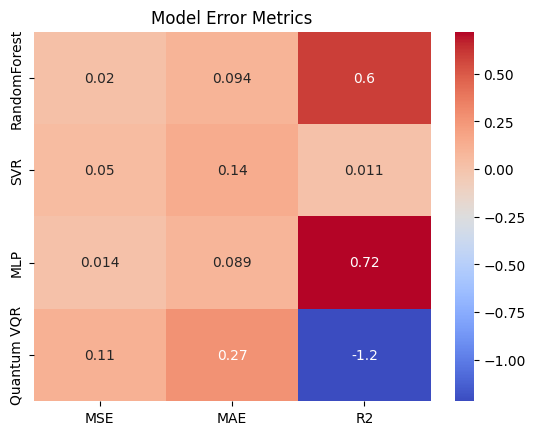

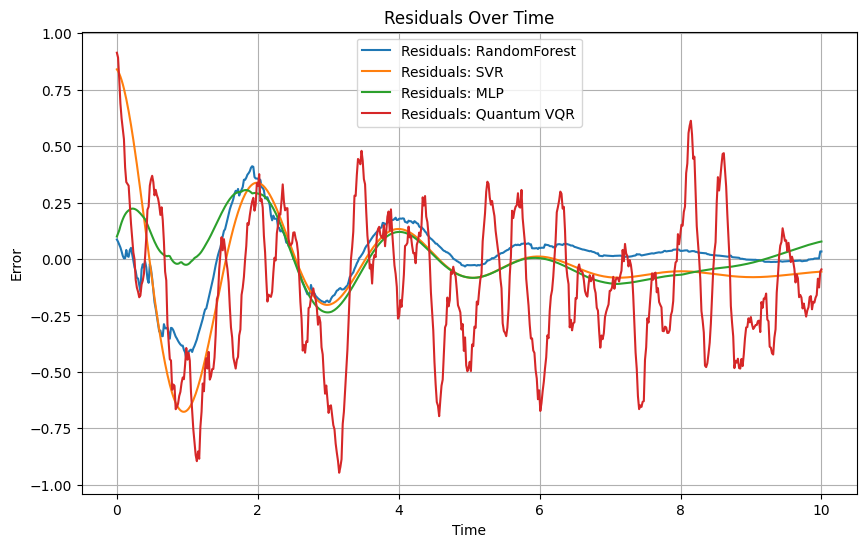

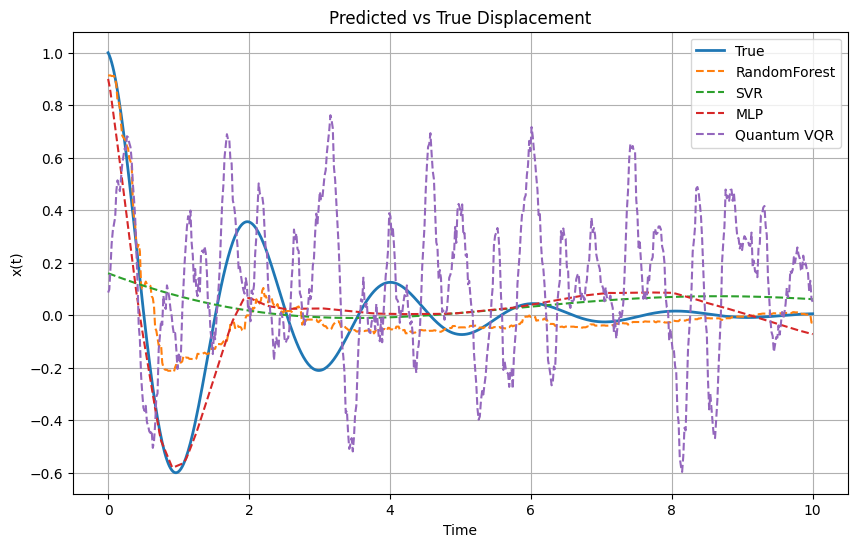

In [11]:
if __name__ == '__main__':
    X, y = generate_damped_oscillator_data(N=1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classical_models = train_classical_models(X_train, y_train)
    quantum_model = train_quantum_model(X_train, y_train)

    X_sample = X_test[0]
    m, k, c, _ = X_sample
    t_vals = np.linspace(0, 10, 600)

    model_preds_sample = {
        name: predict_full_timeseries(model, m, k, c, t_vals)
        for name, model in classical_models.items()
    }
    # Flatten the predictions from the Quantum VQR model
    model_preds_sample['Quantum VQR'] = predict_full_timeseries(quantum_model, m, k, c, t_vals).flatten()

    true_sample_series = true_displacement(m, k, c, t_vals)

    evaluate_models(true_sample_series, model_preds_sample, t_vals)
    animate_model_comparison_detailed_updated(X_sample, model_preds_sample, true_sample_series)